# Learning to move a human arm

This notebook is based on the tutorial from https://github.com/stanfordnmbl/osim-rl.

In [1]:
# Set filenames for saved data from this experiment
file_prefix = 'original'

In [2]:
%matplotlib inline

from environments import MyArmEnv

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

import pickle

def pickledump(obj, fname):
    with open(fname, 'wb') as f:
        return pickle.dump(obj, f)

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from loggers import RewardsLogger, ObservationsLogger
from plots import (plot_observations,
                   plot_reward_history,
                   plot_reward_statistics)

In [5]:
env = MyArmEnv(visualize=False)
input_shape = (1, ) + env.observation_space.shape
nb_actions = env.action_space.shape[0]

## Creating the actor and the critic

The actor serves as a brain for controlling muscles. The critic is our approximation of how good is the brain performing for achieving the goal

In [6]:
# Create actor and critic networks
actor = Sequential()
actor.add(Flatten(input_shape=input_shape))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('sigmoid'))
print(actor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                480       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
__________

In [7]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=input_shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = concatenate([action_input, flattened_observation])
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 1, 14)        0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 6)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 14)           0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20)           0           action_input[0][0]               
                                                                 flatten_2[0][0]                  
__________

## Train the actor and the critic

Train both networks with the DDPG algorithm as implemented in `keras-rl`.

In [8]:
# Set up the agent for training
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(
    theta=.15, mu=0., sigma=.2, dt=env.stepsize, size=env.noutput)
agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    memory=memory,
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,
    random_process=random_process,
    gamma=.99,
    target_model_update=1e-3,
    delta_clip=1.,
)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

In [9]:
# Train the model
training_history = RewardsLogger()
env.reset()
agent.fit(
    env,
    nb_steps=100000,
    visualize=False,
    verbose=1,
    nb_max_episode_steps=200,
    log_interval=10000,
    callbacks=[training_history],
)

# Save weights and training history
agent.save_weights(file_prefix + '_weights.h5f', overwrite=True)
pickledump(training_history, file_prefix + '_training_history.pkl')

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 362s 36ms/step - reward: -1.1222
50 episodes - episode_reward: -224.439 [-675.000, -89.139] - loss: 0.099 - mean_absolute_error: 0.232 - mean_q: -5.193

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 186s 19ms/step - reward: -0.5220
50 episodes - episode_reward: -104.401 [-276.627, -39.135] - loss: 0.194 - mean_absolute_error: 0.375 - mean_q: -9.474

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 206s 21ms/step - reward: -0.4008
50 episodes - episode_reward: -80.166 [-217.052, -33.953] - loss: 0.207 - mean_absolute_error: 0.404 - mean_q: -10.760

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 172s 17ms/step - reward: -0.4041
50 episodes - episode_reward: -80.829 [-149.682, -30.537] - loss: 0.225 - mean_absolute_error: 0.424 - mean_q: -11.369

Interval 5 (40000 steps performed)

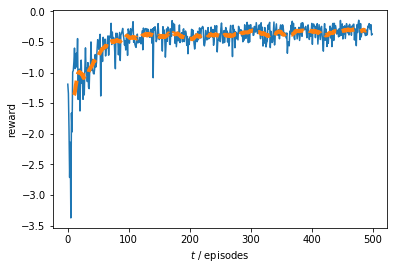

In [15]:
# Plot training reward history
axes = plot_reward_history(training_history)
axes.figure.savefig(file_prefix + '_training_rewards.pdf')

## Evaluate the results
Check how our trained 'brain' performs. We log the full state at each timestep to facilitate all the analysis and visualization we desire.

In [16]:
# Set test parameters
test_nb_episodes = 10
test_nb_max_episode_steps = 1000

In [17]:
# Run test
test_history = ObservationsLogger()
env.reset()
agent.test(
    env,
    nb_episodes=test_nb_episodes,
    visualize=False,
    nb_max_episode_steps=test_nb_max_episode_steps,
    callbacks=[test_history],
)
# Save test history
pickledump(test_history, file_prefix + '_test_history.pkl')

Testing for 10 episodes ...
Episode 1: reward: -339.360, steps: 1000
Episode 2: reward: -287.217, steps: 1000
Episode 3: reward: -289.598, steps: 1000
Episode 4: reward: -305.592, steps: 1000
Episode 5: reward: -227.780, steps: 1000
Episode 6: reward: -334.399, steps: 1000
Episode 7: reward: -267.762, steps: 1000
Episode 8: reward: -305.861, steps: 1000
Episode 9: reward: -248.424, steps: 1000
Episode 10: reward: -307.630, steps: 1000


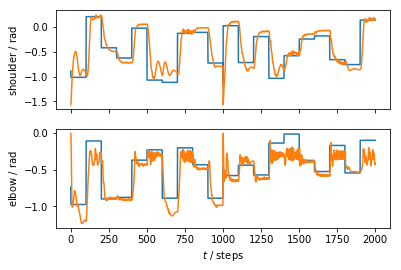

In [18]:
# Plot test observation history
axes = plot_observations(test_history)
axes[0].figure.savefig(file_prefix + '_test_observations.pdf')

## Compare to pretrained model

In [19]:
# Set filenames for saved data from this experiment
file_prefix = 'pretrained'

In [20]:
# Load pretrained weights
agent.load_weights(
    '/home/daniel/packages/osim-rl/models/example.h5f')

In [21]:
# Run test
pretrained_test_history = ObservationsLogger()
env.reset()
agent.test(
    env,
    nb_episodes=test_nb_episodes,
    visualize=False,
    nb_max_episode_steps=test_nb_max_episode_steps,
    callbacks=[pretrained_test_history],
)
# Save test history
pickledump(pretrained_test_history, file_prefix + '_test_history.pkl')

Testing for 10 episodes ...
Episode 1: reward: -266.236, steps: 1000
Episode 2: reward: -234.027, steps: 1000
Episode 3: reward: -325.160, steps: 1000
Episode 4: reward: -256.489, steps: 1000
Episode 5: reward: -217.464, steps: 1000
Episode 6: reward: -291.176, steps: 1000
Episode 7: reward: -259.713, steps: 1000
Episode 8: reward: -347.262, steps: 1000
Episode 9: reward: -251.045, steps: 1000
Episode 10: reward: -239.760, steps: 1000


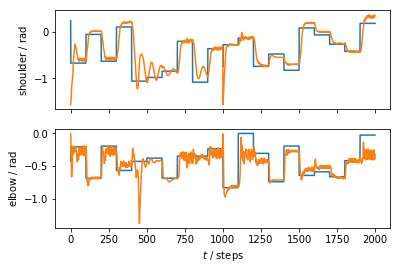

In [22]:
# Plot test observation history
axes = plot_observations(pretrained_test_history)
axes[0].figure.savefig(file_prefix + '_test_observations.pdf')

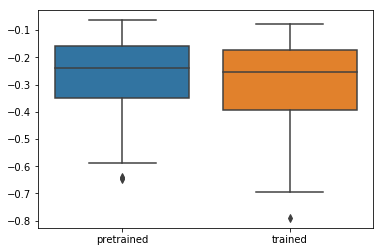

In [30]:
axes = plot_reward_statistics({
    'pretrained': pretrained_test_history,
    'trained': test_history,
})
axes.figure.savefig('pretrained_test_rewards.pdf')